# Visualization Tools

`molli` has great visualization tools that allow for rapid visualization and interaciton with both `Molecule` and `ConformeEnsemble` objects. This is available through Jupyter notebooks and requires `py3Dmol`. This can be installed via `pip install py3Dmol`. An example of how to use this funcitonality is given below

## `Molecule` Visualization Example

In [1]:
# Imports molli
import molli as ml

#Configures visualization tools
ml.visual.configure(bgcolor='white')

#Loads example molecule
dendrobine = ml.load(ml.files.dendrobine_mol2)
dendrobine

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='dendrobine', formula='C16 H25 N1 O2')

## `ConformerEnsemble` Visualization Example

This defaults to show the first conformer as a ball and stick model, while the remaining conformers are rendered as wireframe

In [2]:
clib = ml.ConformerLibrary(ml.files.cinchonidine_rd_conf)
with clib.reading():
    ens = clib['10_4_c']

#Loads example ConformerEnsemble that contains 200 conformers
ens

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

ConformerEnsemble(name='10_4_c', formula='C31 H38 I1 N2 O2')

## `MoleculeLibrary` and `ConformerLibrary` Visualization

Given that Jupyter allows access to `molli` commands, this can be used to see the keys that exist in a library without ever loading it. Example code for this is as follows:

`!molli ls cinchonidine.mlib`

Giving the following result:

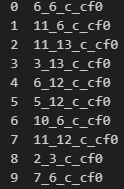

Jupyter also allows for special commands, so the command `%mlib_view` allows for direct visualization of molecules in a `MoleculeLibrary without needing to run a full command to open it. The syntax is as follows:

`%mlib_view <LIB_PATH> <KEY>`

An example is as follows:

`%mlib_view cinchonidine.mlib 3_13_c_cf0`

Giving the following output in the jupyter notebook:

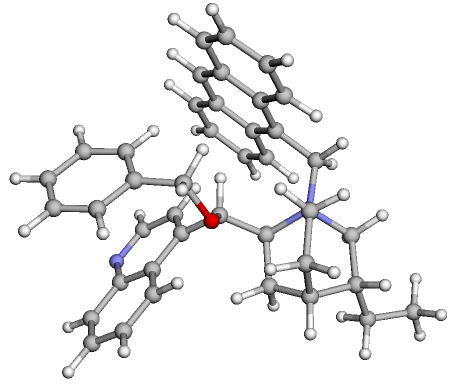

This is the same with serialized `ConformerLibrary` objects using `%clib_view` and the same syntax:

`%clib_view cinchonidine_confs.clib 3_13_c`

Giving the following result in the notebook:

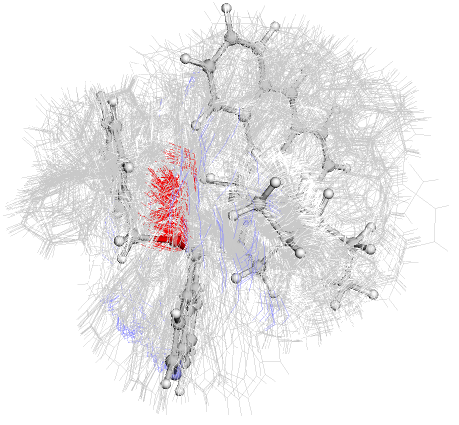

## Visualizaing Molecules with Pyvista

Although the `ml.visual.configure()` by default operates with `py3Dmol`, `pyvista` is also an available backend. This notebook exists as an example of how to utilize pyvista effectively to visualize a Molecule.

`molli 1.2` has not been updated to be compatible with `numpy 2.0` as of yet. As a result, the newest versions of Pyvista. To allow visualization with Pyvista, no version greater than `Pyvista v0.43.10` should be installed.

Note: Pyvista is not natively installed within Molli, but this version can be added through conda using the line:
`pip install pyvista==0.43.10` or `conda install pyvista=0.43.10`

In [3]:
#Imports all necessary dependencies
import molli as ml
import pyvista as pv
from PIL import ImageColor
from matplotlib.colors import ListedColormap
import numpy as np

#This is currently being run on a virtual server and needs a separate server for display via pyvista
pv.start_xvfb()

In [4]:
#Loads Molecule
_mol = ml.load(ml.files.dendrobine_mol2)

#Isoaltes molecule to heavy atoms only
heavy_mol = _mol.heavy

#Centers molecule around the centroid
heavy_mol.translate(-1 * heavy_mol.centroid())

#Returns atom covalent radii for atoms in dendrobine
a_sizes = [a.cov_radius_1 for a in heavy_mol.atoms]

In [5]:
#Sets plot theme
pv.set_plot_theme("dark")  # "document" for light settings!

#Creates plotter available for jupyter notebook
plotter = pv.Plotter(notebook=True)

In [10]:
#Defines Sphere
sph = pv.Sphere(theta_resolution=32, phi_resolution=32)

#Creates lines associated with bonds
b_lines = []
for b in heavy_mol.bonds:
    i1, i2 = map(heavy_mol.get_atom_index, (b.a1, b.a2))
    b_lines.append((2, i1, i2))

#Creates points associated with coordinates
points = pv.PolyData(heavy_mol.coords, lines=b_lines, n_lines=heavy_mol.n_bonds)
points.point_data["element"] = [a.Z for a in heavy_mol.atoms]
points["radius"] = a_sizes

# Creates unique colors associated with elements
val = np.linspace(-1, 118, 120)
colors = np.zeros((120, 4))
for i, elt in enumerate(ml.chem.Element):
    clr = elt.color_cpk or "#000000"
    r, g, b = ImageColor.getrgb(clr)
    colors[val > (elt.z - 0.5)] = [r / 255, g / 255, b / 255, 1]

#Finds actually color mapping
cmap_cpk = pv.LookupTable(
    ListedColormap(colors), n_values=120, scalar_range=(-1, 118)
)

#Creates spheres at coordinates associated with atoms
spherez = points.glyph(
    geom=sph,
    orient=False,
    scale="radius",
    factor=0.5,
    # progress_bar=True,
)

#Creates lines at coordinates associated with bonds
tubez = points.tube(
    radius=0.05,
    # progress_bar=True,
    n_sides=24,
    capping=False,
)

# Adds atoms to the plotter with correct colors
plotter.add_mesh(
    spherez,
    color="white",
    smooth_shading=True,
    scalars="element",
    show_scalar_bar=False,
    diffuse=0.7,
    ambient=0.1,
    specular=0.2,
    specular_power=5,
    cmap=cmap_cpk,
    culling=True,
)

# Adds bonds to the plotter
plotter.add_mesh(
    tubez,
    color="white",
    smooth_shading=True,
    scalars="element",
    show_scalar_bar=False,
    diffuse=0.7,
    ambient=0.1,
    specular=0.2,
    specular_power=5,
    interpolate_before_map=False,
    cmap=cmap_cpk,
    culling=True,
)

# Creates heavy atom labels
heavy = pv.PolyData(heavy_mol.heavy.coords)
heavy["labels"] = [
    f"{a.element.symbol}{i}" for i, a in enumerate(heavy_mol.heavy.atoms)
]

#Adds labels for atoms to the plotter
plotter.add_point_labels(
    heavy,
    "labels",
    font_size=20,
    shadow=True,
    shape_color="white",
    shape_opacity=0.25,
    show_points=False,
    always_visible=True,
    margin=5,
    font_family="courier",
)

#Prepares for plotting
plotter.enable_anti_aliasing(aa_type="msaa", multi_samples=4)
plotter.view_xy()
plotter.add_axes()

#Shows final result
# plotter.show()

<vtkmodules.vtkRenderingAnnotation.vtkAxesActor(0x55eea11bfc40) at 0x7fb38c706080>

Due to a problem with pyvista rendering the plotter on the readthedocs, the output normally seen in this operation is shown below:

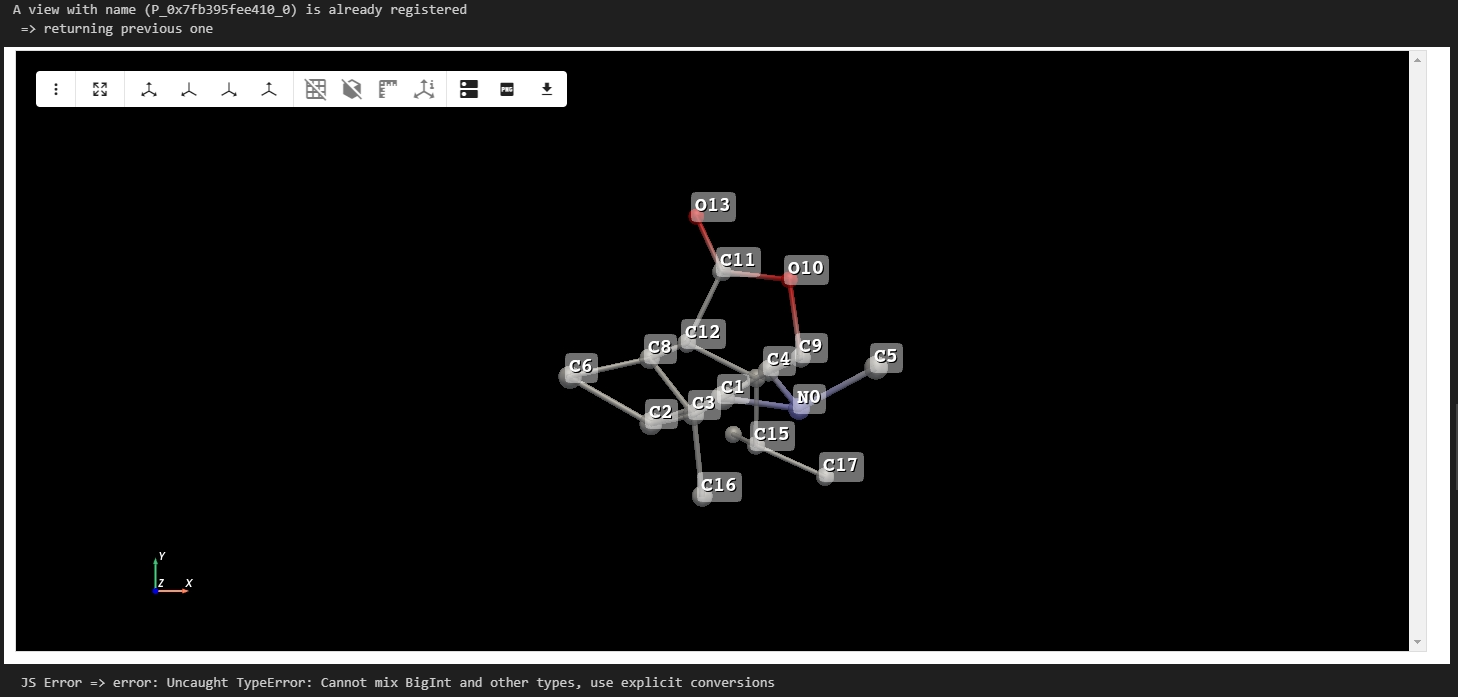

## Visualizing Molecules with Matplotlib

Note: Matplotlib is not natively installed within Molli, but it can be added through conda using the line:

`pip install matplotlib` or `conda install matplotlib`

In [7]:
# Import necessary packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Loads Single Pentane molecule from multi-mol2 file
dendrobine = ml.load(ml.files.dendrobine_mol2, otype='molecule')

# Extracts the symbols of the atoms in the molecule
symbols = [dendrobine.atoms[i].element.symbol for i in range(dendrobine.n_atoms)]

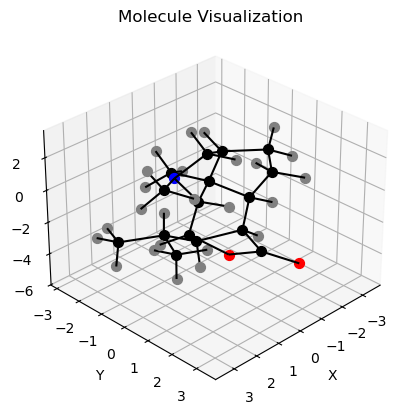

In [8]:
# Create a figure and a 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Adjust the viewing angle
ax.view_init(elev=30, azim=45)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Molecule Visualization')

# Extract x, y, z coordinates of atoms
x_coords = dendrobine.coords[:, 0]
y_coords = dendrobine.coords[:, 1]
z_coords = dendrobine.coords[:, 2]

# Extracts x, y, z coordinates of bonds:


# Extract atomic symbols
color_key = {'C': 'black', 'H': 'grey', 'N': "blue", "O": 'red'}

# Plots the atoms
for i in range(dendrobine.n_atoms):
    ax.scatter(x_coords[i], y_coords[i], z_coords[i],
               color=color_key[symbols[i]], s=50, label=symbols[i])

#Plots the bonds
for i in range(dendrobine.n_bonds):
    bond = dendrobine.get_bond(i)

    bond_a1_idx = dendrobine.get_atom_index(bond.a1)
    bond_a2_idx = dendrobine.get_atom_index(bond.a2)

    line_seg = Line3DCollection([[dendrobine.coords[bond_a1_idx], dendrobine.coords[bond_a2_idx]]],
                                 colors='black', linestyle='solid')
    
    ax.add_collection3d(line_seg)

# Shows the plot
plt.show()

